### 模型2（4）

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize as opt
%matplotlib inline
df_train = pd.read_csv('train.csv')

使用岭回归。为了和Kaggle上的结果比较，我将计算均方根对数误差（RMSLE，但不完全严格，取对数后没有加一），同时按照文档要求，也计算还原为真实值后的均方误差（MSE）代价函数值。

由于样本太少，无法把数据集划分为测试集、验证集与训练集。若划分两次，一次将几乎所有数据列为交叉验证集，一次将所有数据划分为测试集与训练集，则没有意义，而且测试集误差会比较大。所以只将整个数据集用作交叉验证集，用10折交叉验证法同时做调参与测试的工作。

输出1次10折交叉验证的平均RMSLE和均方误差代价函数值的平均值，并以此调参。

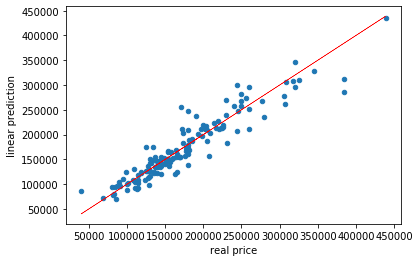

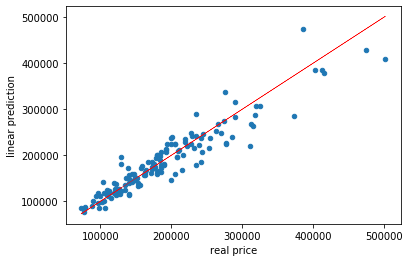

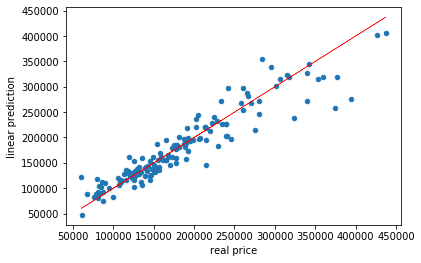

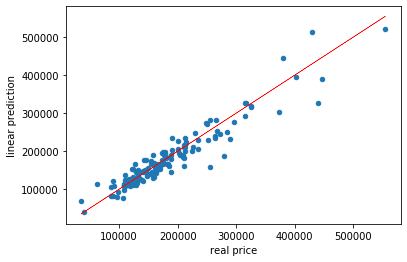

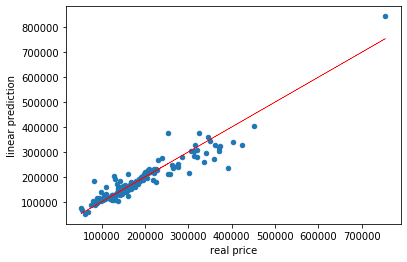

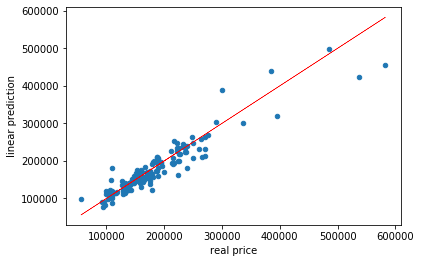

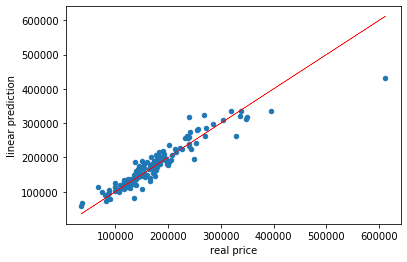

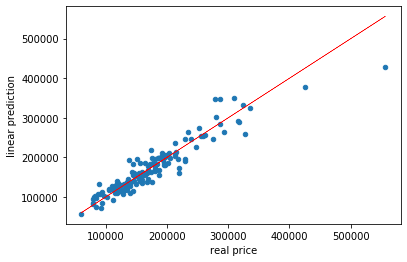

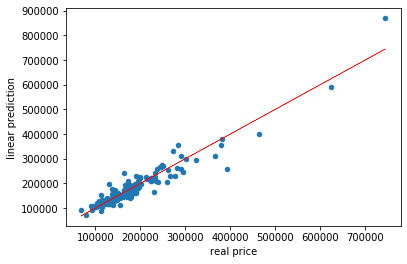

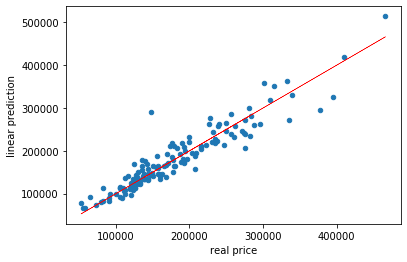

358721897.9551319
0.13725302670166611


In [5]:
# mean squared error
def costFunction(theta, X, y):
    error = np.exp(np.dot(X, theta)) - np.exp(y)
    error = np.squeeze(error)
    cost = np.sum(error ** 2) / (2 * len(X)) 
    return cost


def rootMeanSquaredLogarithmicError(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_pred - y_true)))




# 随机划分原始数据集为测试集约占90%、训练集约占10%。
def trainTestSplit(data, length, start, end):
    df_test=data[start * length : end*length]
    df_test_index=list(df_test.index)
    # 都转换为list来判定成员资格
    df_test_flag=data.index.isin(df_test_index)  
    diff_flag = [not f for f in df_test_flag]
    df_train= data[diff_flag]
    
    X_train = np.empty([len(df_train), len(df_train.values[0])])
    X_test = np.empty([len(df_test), len(df_test.values[0])])
    X_train[:, 0] = 1
    X_test[:, 0] = 1
    for i in range(len(df_train.values[0]) - 1):
        X_train[:, i + 1] = df_train.values[:, i]
    for i in range(len(df_test.values[0]) - 1):
        X_test[:, i + 1] = df_test.values[:, i]
    y_train = df_train['SalePrice'].values
    y_test = df_test['SalePrice'].values
    return X_train, y_train, X_test, y_test

# 岭回归
def ridgeGradientDescent(X, y, theta, alpha, iters, lambdas):
    temp = np.zeros(theta.shape)
    parameters = int(theta.shape[0])
    
    for i in range(iters):
        error = np.dot(X, theta) - y
        error = np.squeeze(error)
        for j in range(parameters):
            X_j = np.squeeze([x[j] for x in X])
            if(j == 0):
                temp[j] = theta[j] - (alpha / len(X)) * np.sum(np.dot(error, X_j))
            else:
                temp[j] = theta[j] - (alpha / len(X)) * (np.sum(np.dot(error, X_j)) + lambdas * theta[j])
            
        theta = temp
        
    return theta



# 1次10折交叉验证调参/评估模型

cost = 0
rmsle = 0
for i in range(10):
    X_train, y_train, X_test, y_test = trainTestSplit(df_train, 145, i, i + 1)
    # 训练10个模型，即每次重新训练模型
    theta = np.zeros(len(df_train.values[0]))
    theta = ridgeGradientDescent(X_train, y_train, theta, 2 * 1e-1, 1000, 7)
    rmsle = rmsle + rootMeanSquaredLogarithmicError(y_test, np.squeeze(np.dot(X_test, theta)))
    cost = cost + costFunction(theta, X_test, y_test)
    predictions = pd.DataFrame({"real price":np.squeeze(np.exp(y_test)), "linear prediction":np.squeeze(np.exp(np.dot(X_test, theta)))})
    predictions.plot(x = "real price", y = "linear prediction", kind = "scatter")
    plt.plot(np.squeeze(np.exp(y_test)), np.squeeze(np.exp(y_test)), c = 'r', linewidth = 0.5)
    plt.show()
    
cost = cost / 10
rmsle = rmsle / 10
print(cost)
print(rmsle)

由于线性回归参数适宜取值区间较大，手工调参即可。

先预设lambda = 0.01，调α、iters。α最初应一个数量级（10倍）一个数量级地调。

当α取0.4-0.1，梯度下降次数约在100以上时，结果最好且RMSLE代价波动范围小于0.1%；设置iters = 300，取0.2时结果最好。

然后调lambda。由于使用了10折交叉验证评估模型，所以只需选取最好的结果即可。当lambda = 7时结果最好。

最后设置iters = 10000，取得最终的10折交叉验证平均cost(价格取了对数)与平均rmsle为0.00947231528367319与0.1372480097992827。结果与iters = 300时几乎没有差别。

值得注意的是，当α取大于等于1时，运行时运算矩阵平方运算时将出现溢出。这表明，16个特征值（算上偏置17个）基本已经达到了算法极限。

我们尝试过使用四十余个特征的数据集。但这样一来特征矩阵规模就太大，并矩阵规模增大时α也要增大才能成功回归（实际上对那个数据集，α值要远大于1才能成功回归），所以即使每个特征值已经缩放到差不多正负1以内了，在α = 1时矩阵平方运算中仍然溢出了。而α小的话，执行结果甚至远不如我们最初试用的α = 1e-6的4特征（算上偏置5个）模型。

从可视化结果可以看出，因为我们的模型使用取对数的saleprice进行训练，对于价格较高的个别长尾样本表现不好，偏差在MSE里被放大了，RMSLE评估会更为合适，这也是Kaggle使用的评估方式。

从Kaggle上的提交数据来看，0.136是还算可以接受的岭回归RMSLE结果，而且这是在调参次数较少情况下得出的，若进行精细调参、提高训练次数的话结果会更好。Kaggle共享文档指出，结果排在前0.3%的算法中使用的岭回归模型，训练集RMSLE也高于0.11。

训练时曾可视化过未还原为真实价格的结果。

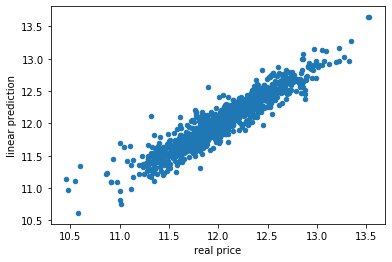

In [81]:
# 可视化完成于还原价格之前
predictions = pd.DataFrame({"real price":y, "linear prediction":np.squeeze(np.dot(X, theta))})
predictions.plot(x = "real price", y = "linear prediction", kind = "scatter")

尝试使用opt自动而更高效地完成回归

In [54]:
def trainTestSplit(X, y, seed):
    X_train = []
    y_train = []
    np.random.seed(seed)
    for i in range(len(y)):
        if np.random.randint(10) != seed:
            X_train.append(X[i, :])
            y_train.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    return X_train, y_train


def ridgeGradientDescent(theta, X, y):
    alpha = 0.5
    lambdas = 0.01
    iters = 100
    temp = np.zeros(theta.shape)
    parameters = int(theta.shape[0])
    
    for i in range(iters):
        error = np.dot(X, theta) - y
        error = np.squeeze(error)
        for j in range(parameters):
            X_j = np.squeeze([x[j] for x in X])
            if(j == 0):
                temp[j] = theta[j] - (alpha / len(X)) * np.sum(np.dot(error, X_j))
            else:
                temp[j] = theta[j] - (alpha / len(X)) * (np.sum(np.dot(error, X_j)) + lambdas * theta[j])
            
        theta = temp
        
    return theta

def costFunction(theta, X, y):
    error = np.dot(X, theta) - y
    error = np.squeeze(error)
    cost = np.sum(error**2)/(2 * len(X))
    return cost


theta = np.zeros(len(df_train.values[0]))
X = np.empty([len(df_train), len(df_train.values[0])])
X[:, 0] = 1
for i in range(len(df_train.values[0]) - 1):
    X[:, i + 1] = df_train.values[:, i]
y = df_train['SalePrice'].values
#for i in range(10):
    #X_train, y_train = trainTestSplit(X, y, i)
    #theta = ridgeGradientDescent(theta, X, y)
temp = opt.fmin_tnc(func = costFunction, x0 = theta.flatten(), fprime = ridgeGradientDescent, args = (X, y.flatten()))
theta = temp[0]
cost = costFunction(theta, X, y)
print(cost)

72.36830061339087


然而，opt.fmin_tnc优化函数的参数条件实在太过苛刻，这一点其实在我使用其他数据集时就发现了。使用4特征数据集时，若不使用opt.fmin_tnc函数，则α取1e-4至1e-6时结果差不多，测试集代价函数结果波动范围小于1%，但使用优化函数后，只有α取le-6时theta才不会被赋值为零。
由于opt.fmin_tnc函数对结果的优化效果非常小，使用条件又太过苛刻，不使用这个函数的时间代价也完全能接受，我选择不使用该函数。

下面用测试集所有数据训练最终模型，然后进行test输出。

In [ ]:
theta = np.zeros(len(df_train.values[0]))
X = np.empty([len(df_train), len(df_train.values[0])])
X[:, 0] = 1
for i in range(len(df_train.values[0]) - 1):
    X[:, i + 1] = df_train.values[:, i]
y = df_train['SalePrice'].values
theta = ridgeGradientDescent(X, y, theta, 2 * 1e-1, 50000, 1)

In [5]:
# test
df_test = pd.read_csv('test.csv')
y_test = np.empty([len(df_test)])
X_test = np.empty([len(df_test), len(df_test.values[0])])
X_test[:, 0] = 1
for i in range(len(df_test.values[0]) - 1):
    X_test[:, i + 1] = df_test.values[:, i + 1]

y_test = np.squeeze(np.exp(np.dot(X_test, theta)))

result = np.empty([len(df_test), 2])
result[:, 0] = df_test.values[:, 0]
result[:, 1] = y_test
our_submission = pd.DataFrame(result)
our_submission.columns = ['Id', 'SalePrice']
our_submission.to_csv('our_submission.csv', index = False)

NameError: name 'theta' is not defined